### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Sofía Hernández Zatarain, Luis Eduardo Sánchez Soto, Cristian Vázquez Plesent.

**Fecha:** 18 de abril del 2023.

**Expediente** : 727151, 734350, 731324.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/sofiahzt/Proyecto

# Proyecto TEMA-2

___
## Desempleo en Estados Unidos.

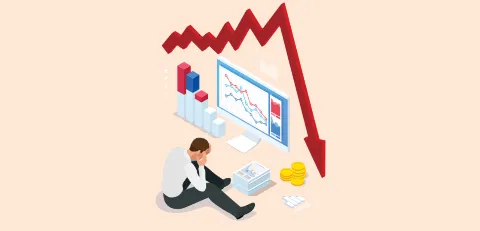

Con este proyecto buscamos analizar el comportamiento de la tasa de desempleo, el PIB, el salario minimo, poblacion e inflación en Estados Unidos a lo largo del tiempo para realizar una proyección de la poblacion desempleada en los siguientes años. 

### 1.2 Objetivos.

**Objetivo general**

Predecir la población desempleada de Estados Unidos durante la siguiente década.

**Objetivos específicos**

* Encontrar la distribución de probabilidad de la población desempleada
* Encontrar la distribución de probabilidad de la tasa de crecimiento del PIB 
* Encontrar la distribución de probabilidad de la tasa de crecimiento de la poblacion
* Encontrar la distribución de probabilidad de la tasa de crecimiento del salario minimo en Estados Unidos
* Encontrar la distribución de probabilidad de la tasa de variacion de la inflacion

### 1.3 Definición del problema.

Considerando que disponemos de un dataset sobre el desempleo en Estados Unidos por estado, haremos una agrupación de los datos en relación a los años establecidos en el frame. Posteriormente obtendrémos las distribuciones de probabilidad de nuestros nodos de interés para así iniciar con las simulaciones. 

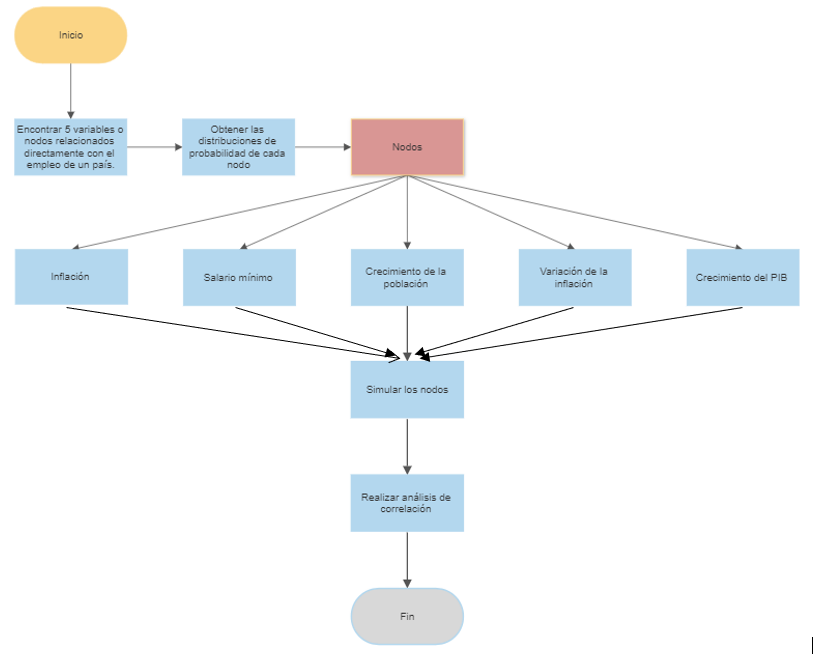

### 1.4 Nodos y variables que se decidieron simular y porqué

* Porcentaje de la fuerza de trabajo desempleada: necesitamos conocer el porcentaje de población desempleada.
* Producto Interno Bruto: indicador del desempeño de la economia, tiene relacion directa con la creacion de nuevos empleos.
* Población en Estados Unidos: si queremos predecir la poblacion desempleada, necesitaremos principalmente predecir la tasa de desempleo y la poblacion desempleada.
* Salario minimo : el salario minimo impacta directamente la demanda de empleos.
* inflacion: importante indicador de la situación economica del pais.  

### 1.5 Definición de hipótesis y supuestos.

**Hipótesis:**

La población de Estados Unidos, el crecimiento de su PIB, crecimiento del salario mínimo, la variación de la inflación y la tasa desempleada están directamente relacionadas y pueden usarse para pronosticar la población desempleada del país.

**Supuestos:**

* No sucederán eventos que impacten desproporcionadamente la tasa de desempleo (pandemia, guerras, crisis)

### 1.6 Obtención de bases de datos

https://www.kaggle.com/datasets/justin2028/unemployment-in-america-per-us-state
https://www.kaggle.com/discussions/general/162174
https://www.kaggle.com/datasets/alexandrepetit881234/us-population-by-state
https://www.kaggle.com/datasets/lislejoem/us-minimum-wage-by-state-from-1968-to-2017
https://datos.bancomundial.org/indicador/FP.CPI.TOTL.ZG?locations=US

In [1]:
import random
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.stats as st
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm 
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde


## Limpieza de datasets

In [2]:
# Obtenemos el Tasa de la fuerza laboral activa desempleada en Estados Unidos
desempleo = pd.read_csv("Unemployment.csv")
desempleo_corr = desempleo.groupby('Year').mean()["Percent (%) of Labor Force Unemployed in State/Area"].iloc[:45]
desempleo = desempleo["Percent (%) of Labor Force Unemployed in State/Area"]

#Obtenemos el salario mínimo en cada Estado por año, deflactado a dolares de 2020
wage = pd.read_csv("Minimum Wage Data.csv", encoding = 'cp1252')
wage_corr = wage.groupby('Year').mean() 
wage_corr = wage_corr["State.Minimum.Wage.2020.Dollars"][8:].rename(index=dict(zip(range(26, 71), range(1976,2021))))
wage = wage.drop(wage[wage["State.Minimum.Wage.2020.Dollars"] == 0].index)
wage = wage["State.Minimum.Wage.2020.Dollars"]

#Cargamos el dataset del PIB y obtenemos los rendimientos de este 
gdp = pd.read_csv("gdp.csv")
gdp = gdp[gdp["Country Name"] == "United States"].drop(columns = ["Country Name", "Code","Unnamed: 65"])
gdp = gdp.iloc[:, 1:].transpose()
gdp['Rendimiento'] = gdp[251].pct_change()
gdp_corr = gdp["Rendimiento"].iloc[15:].rename(index = dict(zip(range(26, 71), range(1976,2021))))
gdp = gdp['Rendimiento'][1:]


#Cargamos el cambio porcentual respecto al año anterior de la población de Estados Unidos
popu = pd.read_csv("pop_us.csv")
popu_corr = pd.DataFrame(popu.iloc[26:-80])
popu_corr = popu_corr.iloc[:,2]
popu_corr = popu_corr.rename(index = dict(zip(range(26, 71), range(1976,2021))))
popu = popu.drop(0)
popu = popu.iloc[:-78]
pop = popu.iloc[:, 2]

#Cargamos la inflación anual resgistrada en Estados Unidos
inf = pd.read_csv("inflacion.csv")
inf = inf[inf["Country Name"]=="Estados Unidos"].drop(columns=["Country Name", "Country Code","Indicator Name", "Indicator Code"]).transpose()
inf_corr = inf.iloc[16:61]
inf_corr = pd.Series(inf_corr[251]).rename(index=dict(zip(range(26, 71), range(1976,2021))))

In [3]:
# Convertir arrays en DataFrames
df1 = pd.DataFrame(desempleo_corr)
df2 = pd.DataFrame(wage_corr)
df4 = pd.DataFrame(popu_corr)
df3 = pd.DataFrame(gdp_corr)
df5 = pd.DataFrame(inf_corr)

# Concatenar DataFrames
df_concatenado_2 = pd.concat([df1, df2, df4], axis=1)
df_concatenado_2.index =  range(1976,2021)
df_concatenado_1 = pd.concat([df3, df5], axis=1)
df_concatenado_1.index =  range(1976,2021)
df_concatenado = pd.concat([df_concatenado_1, df_concatenado_2], axis=1)
df_concatenado = df_concatenado.rename(columns={'Rendimiento': 'PIB %',
                        251: 'Inflación %',
                        'Percent (%) of Labor Force Unemployed in State/Area': 'Desempleo %', 
                                               'State.Minimum.Wage.2020.Dollars': 'Salario Min.',
                                               'Change': 'Población %'})
df_concatenado.head()

,PIB %,Inflación %,Desempleo %,Salario Min.,Change
1976,0.111881,5.744813,7.166195,7.043519,0.94
1977,0.111248,6.501684,6.678145,6.614074,1.02
1978,0.129585,7.630964,5.730503,6.146481,1.13
1979,0.117254,11.254471,5.565094,7.009444,1.18
1980,0.087531,13.549202,6.843868,6.566481,1.21


In [4]:
df_name = df_concatenado.rename(columns = {df_concatenado.columns.values[4]: 'Población %'})
df_name.head()

,PIB %,Inflación %,Desempleo %,Salario Min.,Población %
1976,0.111881,5.744813,7.166195,7.043519,0.94
1977,0.111248,6.501684,6.678145,6.614074,1.02
1978,0.129585,7.630964,5.730503,6.146481,1.13
1979,0.117254,11.254471,5.565094,7.009444,1.18
1980,0.087531,13.549202,6.843868,6.566481,1.21


In [5]:
df_1990 = df_name[14:]
df_1990.head()

,PIB %,Inflación %,Desempleo %,Salario Min.,Población %
1990,0.056999,5.397956,5.442138,5.147407,1.28
1991,0.032698,4.234964,6.500000,6.021481,1.40
1992,0.058816,3.028820,6.966509,6.329630,1.44
1993,0.051873,2.951657,6.422484,6.143889,1.41
1994,0.062502,2.607442,5.705503,6.185185,1.35


## Matriz de correlación

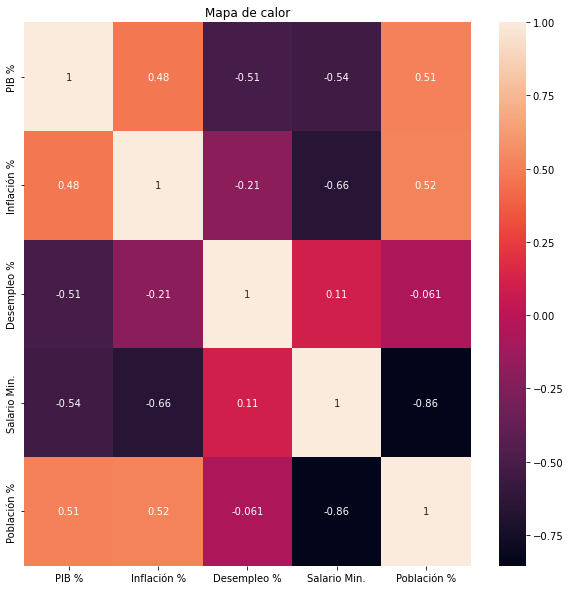

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df_1990.corr(), annot = True)
plt.title('Mapa de calor');

### Conclusiones

* Existe una correlación negativa considerable entre el desempleo y la variable del PIB; es decir, podemos inferir que al disminuir la tasa de desempleo se tiene como resultado un aumento en la producción económica del país
* Entre el desempleo y la inflación tienen una correlación negativa algo débil, por lo que podemos concluir en que a mayor es la tasa de desempleo, los precios de bienes y servicios disminuyen ligeramente
* No podemos afirmar que hay una correlación clara entre el desempleo y el salario mínimo o la población

### 1.7 Visualización de resultados de simulación.
> Se deben simular al menos 4  "nodos" o "escenarios" en tu problema. Para la segunda entrega debes haber elaborado un programa que simule dos de ellos, los primeros dos de tu diagrama.
> Para la entrega final deben de tener los 4 nodos con todas sus simulaciones.

In [7]:
def best_dist( nodo:"Variable a la cual se desea ajustar una distribucion estadistica continua existente"):
    """
    
    Esta función recibe sólo una variable, a la cual ajusta las primeras 20 distribuciones continuas que 
    contiene el paquete scipy. Se comparan las distribuciones contra nuestros datos y se crea un dataFrame para 
    registrar el error cuadrático promedio, se ordena el dataframe de menor a mayor, se almacenan los primeros 5 valores y se 
    crea una lista de estas distribuciones. Posteriormente, itera sobre la lista de distribuciones mejor ajustadas y se grafican
    las funciones de densidad de probabilidad sobre el histograma para mostrar la comparación visual. Por último, se almacenan los 
    parámetros de estas funciones en una lista.
    Esta función regresa la distribución con menor error y sus parámetros, en dos variables.
    """
    y,x,_ = plt.hist(nodo, bins = "auto", density = True)
    x = x[1:]
    
    dist = [d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_continuous"))]
    dist = dist[0:20]
    error = pd.DataFrame(index = dist, columns = ["distribucion", "error"])
    i = 0
    
    for d in dist:
        param = getattr(st, d).fit(nodo)
        y_hat = getattr(st, d).pdf(x, *param)
        error.loc[d] = ((y - y_hat)**2).mean()
    menor_error = error.sort_values(by = "error")
    menor_error = menor_error[0:5]
    dists_menor_error = menor_error.index
    distribucion_menor_error = []
    parametros = []
    for d in dists_menor_error:
        distribucion_menor_error.append(getattr(st,d))
        param = getattr(st,d).fit(nodo)
        y_hat = getattr(st,d)(*param).pdf(x)
        parametros.append(param)
        plt.plot(x,y_hat,label = d)
    plt.legend()
    return distribucion_menor_error[0], parametros[0]

In [8]:
def Q_Q(nodo: "Variable a la que intentamos ajustar una distribución", 
        distribucion: "Nombre de la distribución continua que se compara con los datos", 
        parametros: "Parámetros de la distribución"):
    """
    
    Esta función recibe 3 variables, un nodo datos distribuidos, una distribución continua que comparamos a los datos 
    y, los parametros de dicha distribución.
    Se grafican las frecuencias de nuestros datos junto a una línea que sigue a la distribución propuesta con los parámetros 
    dados, y se comparan las frecuencias obtenidas de nuestros datos en cada cuantil con las frecuencias que debimos haber 
    obtenido teóricamente con la distribución y parámetros asignados y se muestra una recta donde podemos observar visualmente 
    si los datos siguen la distribución o no.
    """
    
    measurements = nodo   
    divisiones = 50 # Cantidad de barras en el histograma
    fig, ax = plt.subplots(2, 1, figsize=(8,8))
    fig.tight_layout(pad = 3.0)

    y, x, _ = ax[0].hist(measurements, divisiones, density = True, label = 'Histograma mediciones')

    # Función de distribución de probabilidad la cual creemos que mis datos distribuyen 
    dist = distribucion
    params = getattr(st, dist).fit(measurements)

    # Graficar PDF de la distribución que queremos probar

    # x = np.arange(measurements.min(), measurements.max(), .01)
    y_hat = getattr(st, dist).pdf(x, *params)
    ax[0].plot(x, y_hat,'r--', label='Distribución ajustada')
    ax[0].set_ylabel('Probability')
    ax[0].grid()

    # gráfica de Q-Q entre mis datos y la curva que quiero probar que sigue mi distribución (dist)
    # Usando scipy
    grap2 = st.probplot(measurements, dist=dist, sparams=getattr(st, dist).fit(x)[:-2], plot=ax[1], fit=True)
    ax[1].grid()
    ax[1].set_title('Usando paquete scipy')

    # plt.xlabel(f'{dist.title()} theorical quantiles')
    # plt.ylabel('Data theorical quantiles')
    plt.show()

In [26]:
def kde_statsmodels_m(x, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    from statsmodels.nonparametric.kernel_density import KDEMultivariate
    kde = KDEMultivariate(x, 
                          #bw=0.1,  #bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return lambda x_grid: kde.pdf(x_grid)

In [10]:
def chi2(pdf: "Distribución a probar",param: "Parámetros",y: "Frecuencias",x:"Histograma"):
    """
    Prueba de Chi Cuadrada. Esta función realiza la prueba de chi cuadrada para una distribución
    dada, con parámetros dados, y el histograma de la distribución obtenido. Obtiene la función
    de distribución de probabilidad de la distribución dada, y calcula el estadístico de Chi2
    para poder determinar si se acepta o se rechaza la Hipótesis Nula. Calcula los grados de 
    libertad en base a la longitud de datos recibidos del histograma.
    """
    J = len(x)
    pi = dist.pdf(x,*param)
    #Cálculo de Esperanza de la distribución teórica
    Ei = x*pi
    #Cálculo teórico de la chi2
    chi2 = ((y - Ei)**2 / Ei).sum()
    print("Valor teórico de Chi2 =",chi2)
    #Cálculo mediante librería de chi2
    CHI2 = st.chisquare(y,Ei)
    print("Valor por librería de Chi2 =",CHI2)
    #Grados de libertad
    m = J-1
    #Obtención del estadístico de Chi2
    Chi_st = st.chi2.ppf(q=0.95,df=m)
    print("Estadístico de Chi2 =", Chi_st) 

In [11]:
def chi2(dist: "Distribución a probar",param: "Parámetros",y: "Frecuencias",x:"Histograma"):
    """
    Prueba de Chi Cuadrada. Esta función realiza la prueba de chi cuadrada para una distribución
    dada, con parámetros dados, y el histograma de la distribución obtenido. Obtiene la función
    de distribución de probabilidad de la distribución dada, y calcula el estadístico de Chi2
    para poder determinar si se acepta o se rechaza la Hipótesis Nula. Calcula los grados de 
    libertad en base a la longitud de datos recibidos del histograma.
    """
    J = len(x)
    pi = dist.pdf(x,*param)
    #Cálculo de Esperanza de la distribución teórica
    Ei = x*pi
    #Cálculo teórico de la chi2
    chi2 = ((y - Ei)**2 / Ei).sum()
    print("Valor teórico de Chi2 =",chi2)
    #Cálculo mediante librería de chi2
    CHI2 = st.chisquare(y,Ei)
    print("Valor por librería de Chi2 =",CHI2)
    #Grados de libertad
    m = J-1
    #Obtención del estadístico de Chi2
    Chi_st = st.chi2.ppf(q=0.95,df=m)
    print("Estadístico de Chi2 =", Chi_st) 

In [43]:
def red_var(nodo):

# Función inversa (vista en clases anteriores)
    xi = lambda u: 100/u

# Parámetros de reducción de varianza
    n = 100  # tamaño de la muestra
    B = 100  # número de muestras bootstrap

# Muestreo aleatorio simple
    muestras = nodo.sample(n = n, replace = True, random_state = 123)

# Calcular medias muestrales
    medias_muestrales = []
    for i in range(B):
        muestra_bootstrap = muestras.sample(n = n, replace = True, random_state = i)
        medias_muestrales.append(xi(muestra_bootstrap).mean())

# Calcular media de las medias muestrales
    media_bootstrap = np.mean(medias_muestrales)

# Mostrar resultados
    print(f"La media muestral estimada es: {xi(muestras).mean()}")
    print(f"La media muestral estimada con reducción de varianza es: {media_bootstrap}")
    print(f"Error relativo: {(1-media_bootstrap/xi(muestras).mean())*100}%")

## Nodos

### Desempleo

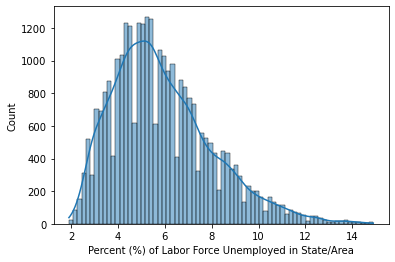

In [53]:
desempleo = desempleo[desempleo < 15]
sns.histplot(desempleo, kde = True);

In [12]:
df_desempleo = pd.DataFrame(desempleo)
df_desempleo

,Percent (%) of Labor Force Unemployed in State/Area
0,6.6
1,7.1
2,10.2
3,7.3
4,9.2
...,...
29887,3.1
29888,4.5
29889,4.1
29890,3.0


### Escoger la mejor distribución

(2.1598126239255855, 6.772396638866233, 1.875266139892446, 10.447482922523973)

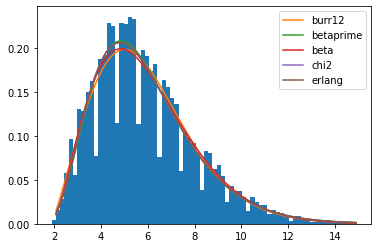

In [14]:
d,p = best_dist(desempleo)
p

### Hipótesis nula

* La función de distribución que mejor se ajusta a los datos de la variable _desempleo_ es la burr12

### Hipotesis alternativa

* Los datos de la variable _desempleo_ no siguen una distribución burr12

### Comprobación de distribución

### Q-Q

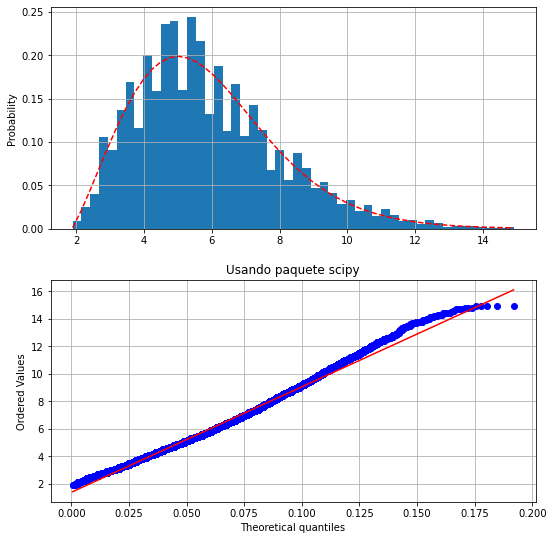

In [15]:
dist = "burr12"
Q_Q(desempleo, dist, p)

**Desde el análisis Q-Q, podemos observar una distribución ligeramente sesgada hacia la derecha y que se ajusta bien a los datos**

### Función de densidad de probabilidad utilizando la estimación de kernel

In [55]:
# dist: "Distribución a probar", param: "Parámetros", y: "Frecuencias", x:"Histograma"

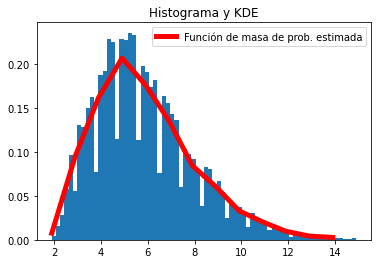

In [16]:
dom = np.arange(0,31)
plt.hist(desempleo, bins = "auto",density = True)
desempleo_fun = kde_statsmodels_m(desempleo)
plt.plot(dom, desempleo_fun(dom), label = 'Función de masa de prob. estimada', color = 'r', linewidth = 5)
plt.title("Histograma y KDE")
plt.legend()
plt.show()

**Analizando visualmente ambas gráficas, podemos inferir que una distribución burr12 se ajusta mejor a los datos que una KDE**

### $Chi^2$ 

### Reducción de Varianza

In [48]:
red_var(desempleo)

La media muestral estimada es: 18.309478046656128
La media muestral estimada con reducción de varianza es: 18.293826538231592
Error relativo: 0.08548309451887892%


### Salario mínimo

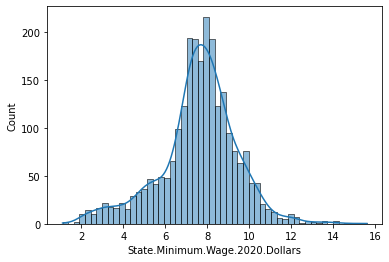

In [51]:
sns.histplot(wage, kde = True);

In [52]:
df_wage = pd.DataFrame(wage)
df_wage

,State.Minimum.Wage.2020.Dollars
1,15.61
2,3.48
3,1.16
4,12.26
5,7.43
...,...
2857,7.25
2858,13.50
2859,8.75
2860,7.25


### Escoger la mejor distribución

(1.1102406204764472, 7.710151784804342, 1.2201665654629594)

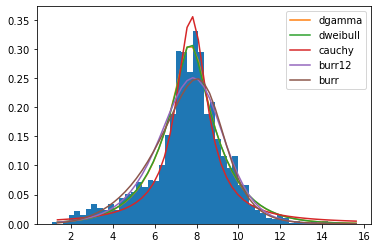

In [23]:
d,p = best_dist(wage)
p

### Hipótesis nula

* Los datos de la variable _Salario Mínimo_ se ajustan a una distribución dgamma

### Hipótesis alternativa

* La distribución dgamma no es la apropiada para el conjunto de datos de la variable _Salario Mínimo_

In [55]:
montecarlo(pdf,desempleo)

Con una confianza de 0.95 la media estará en el intervalo,
 (2.6614653664990584, 10.87215385132288)
Media calculada 5.895312657166786


### Comprobación de distribución

### Q-Q

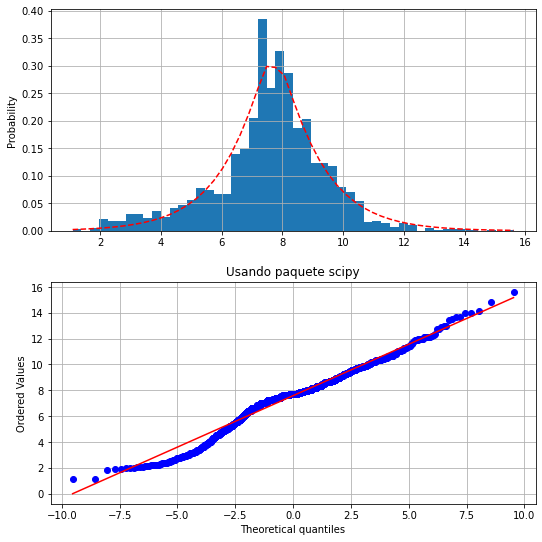

In [24]:
dist="dgamma"
Q_Q(wage,dist,p)

**No observamos a simple vista ningún sesgo en particular, podemos apreciar que la distribución se adapta bastante bien a los datos**

### Función de densidad de probabilidad utilizando la estimación de kernel

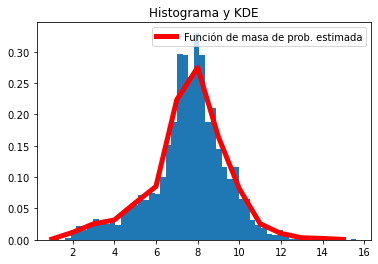

In [56]:
dom = np.arange(1,16)
plt.hist(wage,bins="auto",density=True)
wage_fun = gaussian_kde(wage)
plt.plot(dom, wage_fun(dom), label='Función de masa de prob. estimada', color='r', linewidth=5)
plt.title("Histograma y KDE")
plt.legend()
plt.show()

**A partir de un análisis visual de las gráficas, podemos inferir que dgamma es la distribución apropiada para el conjunto de datos de esta variable**

### $Chi^2$ 

### Reducción de Varianza

In [57]:
red_var(wage)

La media muestral estimada es: 14.738328304370048
La media muestral estimada con reducción de varianza es: 14.729483313379125
Error relativo: 0.06001352940618876%


### Crecimiento del PIB

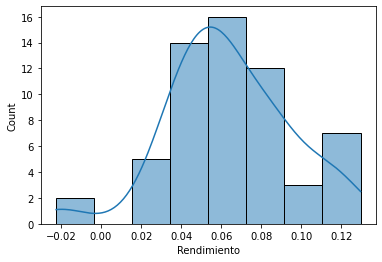

In [59]:
sns.histplot(gdp, kde = True);

In [66]:
df_gdp = pd.DataFrame(gdp)
df_gdp.tail()

,Rendimiento
2016,0.027786
2017,0.042566
2018,0.054694
2019,0.039849
2020,-0.022404


(2069.7093485112573,
 210.56733639710876,
 -4.475712633112741,
 5.0011862913466505)

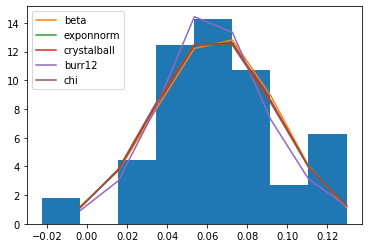

In [63]:
d,p = best_dist(gdp)
p

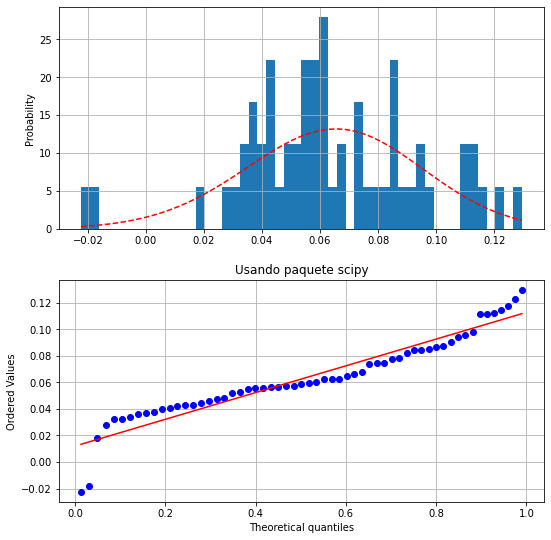

In [64]:
dist="crystalball"
Q_Q(gdp,dist,p)

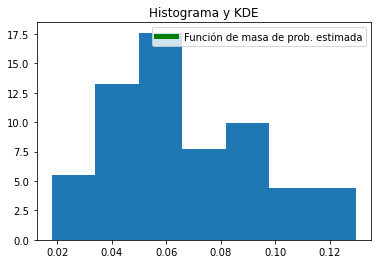

In [65]:
dom = np.arange(gdp.min(), gdp.max())
plt.hist(gdp,bins="auto",density=True)
gdp_fun = kde_statsmodels_m(gdp)
plt.plot(dom, gdp_fun(dom), label='Función de masa de prob. estimada', color='g', linewidth=5)
plt.title("Histograma y KDE")
plt.legend()
plt.show()

#### Poblacion

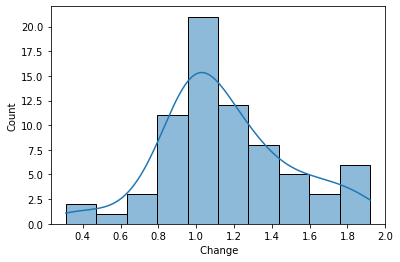

In [31]:
sns.histplot(pop, kde=True);

(7964.7387142787775,
 0.5559986202602145,
 -1128.6833630958586,
 1129.6714857420661)

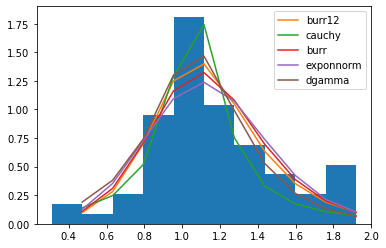

In [32]:
d,p = best_dist(pop)
p

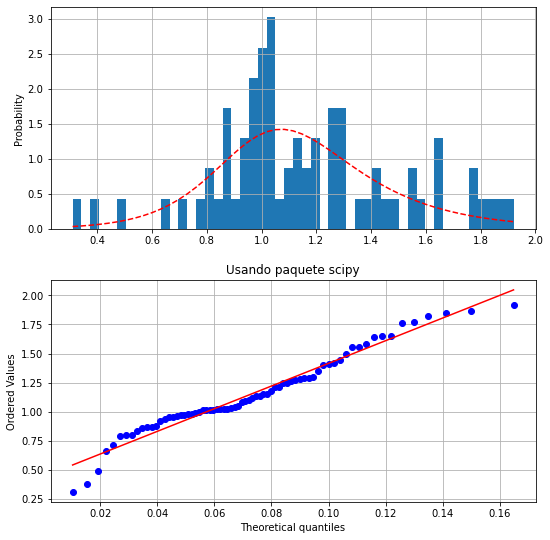

In [33]:
dist="burr12"
Q_Q(pop,dist,p)

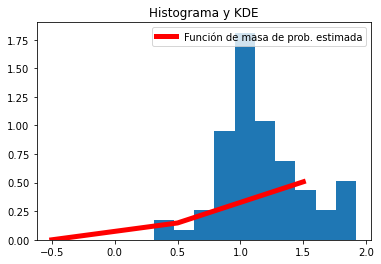

In [34]:
dom = np.arange(-0.5,2)
plt.hist(pop,bins="auto",density=True)
pop_fun = kde_statsmodels_m(pop)
plt.plot(dom, pop_fun(dom), label='Función de masa de prob. estimada', color='r', linewidth=5)
plt.title("Histograma y KDE")
plt.legend()
plt.show()

#### Inflación

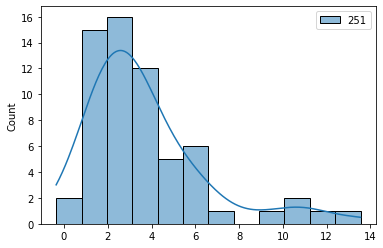

In [35]:
sns.histplot(inf,kde=True);

(3.8886572605513727,
 2.0139383107821436,
 -2.4326978306349414,
 4.347947760356947)

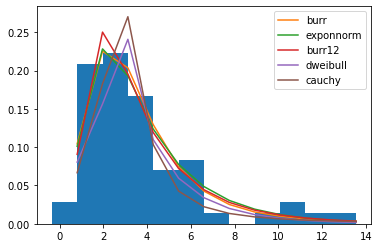

In [36]:
d,p = best_dist(inf)
p

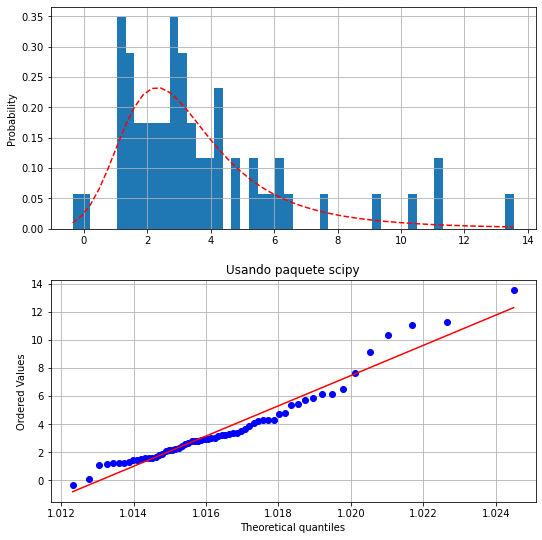

In [37]:
dist="burr"
Q_Q(inf[251],dist,p)

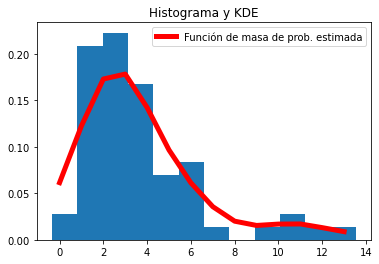

In [38]:
dom = np.arange(0,14)
plt.hist(inf,bins="auto",density=True)
inf_fun = kde_statsmodels_m(inf)
plt.plot(dom, inf_fun(dom), label='Función de masa de prob. estimada', color='r', linewidth=5)
plt.title("Histograma y KDE")
plt.legend()
plt.show()

In [39]:
desv = desempleo.std()
med = data["Points"].std()
data["Points_norm"] = (data["Points"] - med) / desv
data

NameError: name 'data' is not defined

___
## 2. Especificaciones adicionales.
En el grupo deben haber mínimo dos integrantes y máximo tres integrantes. Para propósitos logísticos nada más, por favor enumérense como *integrante 1*, *integrante 2* e *integrante 3*.

### 2.1 Notebook de jupyter. 
> Los anteriores numerales los deben desarrollar todos en un notebook de jupyter y llamarlo de la siguiente manera `ProyectoModulo1_ApellidoN1_ApellidoN2_ApellidoN3`, donde `ApellidoNi` hace referencia al apellido materno y la inicial del primer nombre del integrante `i`.

### 2.2 Proyecto en `GitHub`.
> El integrante 1 deberá crear un proyecto en `GitHub` llamado **proyecto_modulo1**, donde tendrán todos los archivos relacionados con el proyecto. Los demás integrantes deben hacer un *fork* del proyecto, seguir el proyecto principal con `GitKraken` y hacer al menos dos contribuciones con *pull request* (como se hizo en la tarea). En el proyecto, deben incluir el repositorio remoto del integrante 1.

### 2.3 Presentación.
> Recuerden que la nota del proyecto es mitad el trabajo, y mitad la presentación. Deben hacer una presentación ya sea en power point o utlizando un notebook de python para presentar el trabajo durante un horario de clase que se será posteriomente definido. La presentación, además de llevar todos los componentes básicos descritos en el entregable, debe llevar una tabla de contenido.
> - Presentación: 10 minutos.
> - Seguir estas recomendaciones: https://es.slideshare.net/MeireComputacion/power-point-pautas-para-una-buen-trabajo

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>